In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the data into a DataFrame
abtest = pd.read_excel("AssignmentData.xlsx", sheet_name="ABTest")

# Perform exploratory analysis
abtest.head()

,Date,Device,Address,Clicks,Visitors,Group
0,2023-05-18,Mobile,fyttlyf/business/campaign/campaigns-business/c...,159,199,Control
1,2023-05-18,Laptop,fyttlyf/business/campaign/get-paid///,18,1413,Experiment
2,2023-05-18,Mobile,fyttlyf/business/campaign/campaigns-business/s...,142,759,Control
3,2023-05-18,Laptop,fyttlyf/business/product/business-financial-se...,126,473,Control
4,2023-05-18,Laptop,fyttlyf/business/product/business-accept-payme...,129,183,Control


In [4]:
abtest.info() # Summary of DataFrame including data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18099 entries, 0 to 18098
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      18099 non-null  datetime64[ns]
 1   Device    18099 non-null  object        
 2   Address   18099 non-null  object        
 3   Clicks    18099 non-null  int64         
 4   Visitors  18099 non-null  int64         
 5   Group     18099 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 848.5+ KB


In [5]:
abtest.describe()

,Clicks,Visitors
count,18099.000000,18099.000000
mean,62.600033,495.485441
std,377.536611,5704.920360
min,0.000000,0.000000
25%,6.000000,21.000000
50%,11.000000,33.000000
75%,20.000000,97.000000
max,11199.000000,211868.000000


In [6]:
abtest['Date'] = pd.to_datetime(abtest['Date'])

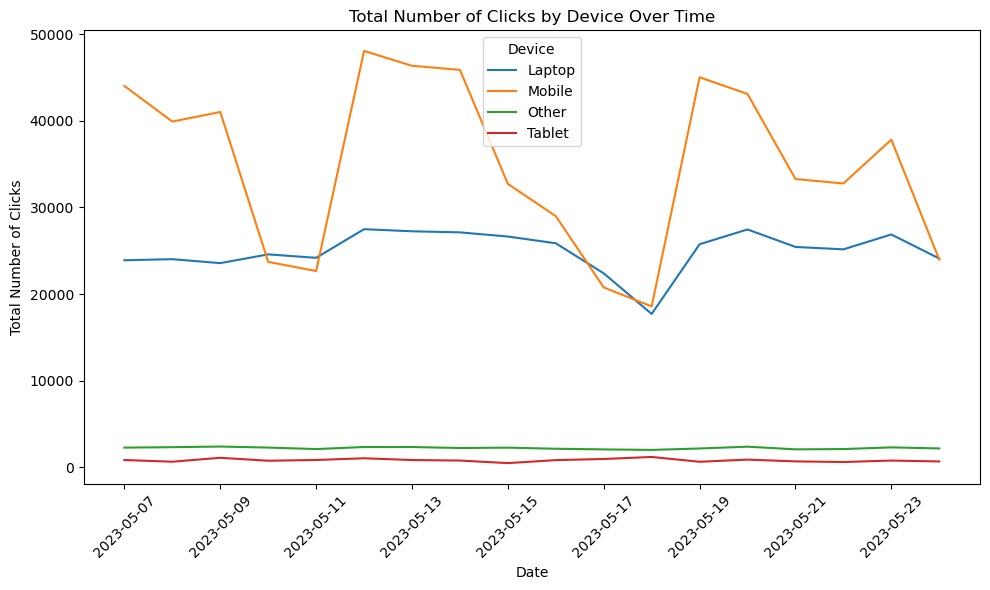

In [9]:
# Group by 'Date' and 'Device' to get total number of clicks for each combination
clicks_by_device_date = abtest.groupby(['Date', 'Device'])['Clicks'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=clicks_by_device_date, x='Date', y='Clicks', hue='Device')
plt.title('Total Number of Clicks by Device Over Time')
plt.xlabel('Date')
plt.ylabel('Total Number of Clicks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Device')
plt.show()


In [13]:
# Assuming 'abtest' is the DataFrame containing the A/B test data

# Calculate baseline conversion rate for the control group
baseline_conversion_rate_control = abtest[(abtest['Group'] == 'Control')]['Clicks'].sum() / abtest[(abtest['Group'] == 'Control')]['Visitors'].sum()

# Calculate baseline conversion rate for the treatment group
baseline_conversion_rate_treatment = abtest[(abtest['Group'] == 'Experiment')]['Clicks'].sum() / abtest[(abtest['Group'] == 'Experiment')]['Visitors'].sum()

# Calculate expected lift
expected_lift = baseline_conversion_rate_treatment - baseline_conversion_rate_control

print("Baseline Conversion Rate (Control):", baseline_conversion_rate_control)
print("Baseline Conversion Rate (Treatment):", baseline_conversion_rate_treatment)
print("Expected Lift:", expected_lift)


Baseline Conversion Rate (Control): 0.1096500442226737
Baseline Conversion Rate (Treatment): 0.2608438730766084
Expected Lift: 0.15119382885393468


In [14]:
from statsmodels.stats.power import TTestIndPower

# Set parameters
baseline_conversion_rate = 0.11  # 11%
expected_lift = 0.26  # 26%

# Calculate pooled standard deviation
pooled_std_dev = ((baseline_conversion_rate * (1 - baseline_conversion_rate)) + ((baseline_conversion_rate + expected_lift) * (1 - (baseline_conversion_rate + expected_lift)))) ** 0.5

# Calculate effect size
effect_size = expected_lift / pooled_std_dev

# Initialize TTestIndPower object
power_analysis = TTestIndPower()

# Calculate sample size
sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=0.05, power=0.80, alternative='larger')

print("Required Sample Size:", round(sample_size))


Required Sample Size: 61


In [15]:
actual_sample_size = len(abtest)
print("Actual Sample Size:", actual_sample_size)

Actual Sample Size: 18099


In [16]:
from scipy.stats import norm

def perform_ab_test(control_visitors, control_conversions, treatment_visitors, treatment_conversions, confidence_level):
    # Calculate conversion rates
    control_conversion_rate = control_conversions / control_visitors
    treatment_conversion_rate = treatment_conversions / treatment_visitors
    
    # Calculate pooled probability
    pooled_probability = (control_conversions + treatment_conversions) / (control_visitors + treatment_visitors)
    
    # Calculate pooled standard error
    pooled_std_error = (pooled_probability * (1 - pooled_probability) * ((1 / control_visitors) + (1 / treatment_visitors))) ** 0.5
    
    # Calculate z-score
    z_score = (treatment_conversion_rate - control_conversion_rate) / pooled_std_error
    
    # Determine critical value based on confidence level
    if confidence_level == 90:
        critical_value = norm.ppf(0.95)
    elif confidence_level == 95:
        critical_value = norm.ppf(0.975)
    elif confidence_level == 99:
        critical_value = norm.ppf(0.995)
    else:
        raise ValueError("Invalid confidence level. Choose from 90, 95, or 99.")
    
    # Compare z-score with critical value
    if z_score > critical_value:
        return "Experiment Group is Better"
    elif z_score < -critical_value:
        return "Control Group is Better"
    else:
        return "Indeterminate"

# Example usage:
# Replace the arguments with actual values from your dataset
result = perform_ab_test(control_visitors=500, control_conversions=50, treatment_visitors=550, treatment_conversions=70, confidence_level=95)
print("AB Test Result:", result)


AB Test Result: Indeterminate


In [17]:
# import pandas as pd

# Assuming 'data' is the DataFrame containing your data
# First, filter the DataFrame to separate control and treatment groups
control_data = abtest[abtest['Group'] == 'Control']
treatment_data = abtest[abtest['Group'] == 'Experiment']

# Next, calculate the number of visitors and conversions for each group
control_visitors = control_data['Visitors'].sum()
control_conversions = control_data['Clicks'].sum()
treatment_visitors = treatment_data['Visitors'].sum()
treatment_conversions = treatment_data['Clicks'].sum()

# Now, call the perform_ab_test function with the calculated values
result = perform_ab_test(control_visitors, control_conversions, treatment_visitors, treatment_conversions, confidence_level=95)
print("AB Test Result:", result)


AB Test Result: Experiment Group is Better
